In [18]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms as tf

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [19]:
def set_seeds(seed: int = 42):
    """
    Sets random seed for reproducibility.
    :param seed: (int, optional): Random seed. Defaults to 42
    :return: 
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [20]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [21]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(f"Using device: {device}")    

Using device: cpu


# Create Celebs Dataset

In [22]:
from dataset import CelebDataset

In [23]:
train_dataset = CelebDataset(mode='train')
val_dataset = CelebDataset(mode='val')
test_dataset = CelebDataset(mode='test')

# Let's look at cropped images from celeb dataset

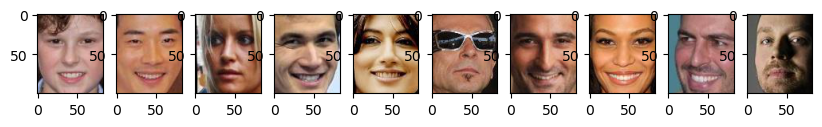

In [24]:
import random

nrows, ncols = 1,  10
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 7))
ax = ax.flatten()
to_pil = tf.ToPILImage()
for i in range(nrows * ncols):
    rand_index = random.randint(0, len(train_dataset) - 1)
    image_tensor = train_dataset.__getitem__(rand_index)[0]
    pil_image = to_pil(image_tensor)
    ax[i].imshow(pil_image)



# # Plot more images
# torch.manual_seed(42)
# fig = plt.figure(figsize=(9, 9))
# rows, cols = 4, 4
# for i in range(1, rows * cols + 1):
#     random_idx = torch.randint(0, len(train_data), size=[1]).item()
#     img, label = train_data[random_idx]
#     fig.add_subplot(rows, cols, i)
#     plt.imshow(img.squeeze(), cmap="gray")
#     plt.title(class_names[label])
#     plt.axis(False);


In [25]:
batch_size = 64

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size)

## Train Loop

Let's describe a train function which we well user for all experiments with face recognition.

In [26]:
# def eval_accuracy(model: Module, dataloader: DataLoader):
#     model.eval()
#     timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
#     summary_writer = SummaryWriter(f'runs/face_recognition_trainer_{timestamp}')
#     for _, (images, labels) in enumerate(dataloader):
#         with torch.no_grad():
#             outputs = model(images)
#             
        


# ResNet + Cross-Entropy Loss

Let's use pretrained ResNet network. Here I change fully-connected layers and freeze convolutional layers to relearn the network to recognize faces. 

In [27]:
from torchvision.models import resnet34, ResNet101_Weights, ResNet

model: ResNet = resnet101(weights=ResNet101_Weights.IMAGENET1K_V1)

# Freeze feature parameters in the "feature" section of the model, because we want to train only classifier
for param in model.parameters():
    param.requires_grad = False

set_seeds()
# Let's assign a brand-new classifier to our model. We will train it during train procedure
num_features = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(in_features=num_features, out_features=num_features * 2),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=num_features * 2, out_features=num_features),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=num_features, out_features=128),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=128, out_features=128),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=128, out_features=500)
)

In [28]:
# Let's look at network architecture
from torchinfo import summary
summary(
    model=model,
    input_size=(32, 3, 224, 224),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20
)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
ResNet                                   [32, 3, 224, 224]    [32, 500]            --                   Partial
├─Conv2d: 1-1                            [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU: 1-3                              [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d: 1-4                         [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential: 1-5                        [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck: 2-1                   [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

## Loss Function and Optimizer

In [29]:
criterion = F.cross_entropy
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=)

## Run Train Loop

In [30]:
from train import train

set_seeds()

history = train(
    epochs=50,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    device=device
)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | Train loss 6.2165 | Train accuracy 0.0000 | Validation loss 6.2164 | Validation accuracy 0.0000
Epoch: 2 | Train loss 6.2163 | Train accuracy 0.0000 | Validation loss 6.2163 | Validation accuracy 0.0000
Epoch: 3 | Train loss 6.2163 | Train accuracy 0.0000 | Validation loss 6.2162 | Validation accuracy 0.0000
Epoch: 4 | Train loss 6.2162 | Train accuracy 0.0000 | Validation loss 6.2161 | Validation accuracy 0.0000
Epoch: 5 | Train loss 6.2162 | Train accuracy 0.0000 | Validation loss 6.2162 | Validation accuracy 0.0000
Epoch: 6 | Train loss 6.2161 | Train accuracy 0.0000 | Validation loss 6.2160 | Validation accuracy 0.0000
Epoch: 7 | Train loss 6.2160 | Train accuracy 0.0000 | Validation loss 6.2170 | Validation accuracy 0.0000
Epoch: 8 | Train loss 6.2159 | Train accuracy 0.0000 | Validation loss 6.2158 | Validation accuracy 0.0000
Epoch: 9 | Train loss 6.2158 | Train accuracy 0.0000 | Validation loss 6.2158 | Validation accuracy 0.0000
Epoch: 10 | Train loss 6.2157 | Train

KeyboardInterrupt: 

In [ ]:
history

In [ ]:
from ir.metric import compute_ir_metric

In [ ]:
compute_ir_metric(model, fpr=0.1, device=device)

In [32]:
from torchvision.models import vgg19, VGG19_Weights, VGG, resnet18, ResNet, ResNet18_Weights
from torchinfo import summary

model: ResNet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

summary(
    model=model,
    input_size=(32, 3, 224, 224),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20
)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
ResNet                                   [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d: 1-1                            [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU: 1-3                              [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d: 1-4                         [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential: 1-5                        [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]     [32, 64, 56, 56]     36,864               True
│    │    └─BatchN

In [33]:
from torchvision.transforms import v2

ImportError: cannot import name 'DisableTorchFunctionSubclass' from 'torch._C' (/Users/iliamikheev/anaconda3/envs/face-recognizing/lib/python3.8/site-packages/torch/_C.cpython-38-darwin.so)

In [34]:
v2.ToDtype()

NameError: name 'v2' is not defined

In [37]:
import albumentations as A

In [38]:
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights, EfficientNet

model: EfficientNet = efficientnet_b3(EfficientNet_B3_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /Users/iliamikheev/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth


  0%|          | 0.00/47.2M [00:00<?, ?B/s]

In [39]:
summary(
    model=model,
    input_size=(32, 3, 224, 224),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20
)

Layer (type:depth-idx)                                  Input Shape          Output Shape         Param #              Trainable
EfficientNet                                            [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential: 1-1                                       [32, 3, 224, 224]    [32, 1536, 7, 7]     --                   True
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]    [32, 40, 112, 112]   --                   True
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]    [32, 40, 112, 112]   1,080                True
│    │    └─BatchNorm2d: 3-2                            [32, 40, 112, 112]   [32, 40, 112, 112]   80                   True
│    │    └─SiLU: 3-3                                   [32, 40, 112, 112]   [32, 40, 112, 112]   --                   --
│    └─Sequential: 2-2                                  [32, 40, 112, 112]   [32, 24, 112, 112]   --                   True
│    